In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits
from uncertainties import ufloat
from astropy.cosmology import FlatLambdaCDM
np.random.seed(3_141_592_653)

# Definiendo modelo cosmologico para estimar distancias en función del redshift.


In [62]:
# Define the redshift
z = 0.077985 # +- 1.917881e-5 redshift/corrimiento al rojo
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distance = cosmo.comoving_distance(z).value
lumDist= cosmo.luminosity_distance(z).to('cm').value
#d = LD*3.086e+24 # cm
#print("Distance: {:.2f} Mpc".format(distance))
#print("Distance: {:.2f}".format(LD/1e24))
#print(d)

## Unas cuantas funciones para modelar las lineas de emisión: 1, 2 y 3 gaussianas.

In [63]:
# Define the function to fit (a Gaussian curve)
def recta(x,m):
    return m*x

def gaussian(x, mu, sigma, A, c):
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + c

# Define another function to fit (two Gaussian curves)
def doubleGaussian(x, mu1, sigma1, A1, mu2, sigma2, A2, c):
    return A1*np.exp(-(x-mu1)**2/(2*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2*sigma2**2)) + c

# Define another function to fit (three Gaussian curves)
def tripleGaussian(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3, c):
    return A1*np.exp(-(x-mu1)**2/(2*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2*sigma2**2)) + A3*np.exp(-(x-mu3)**2/(2*sigma3**2)) + c


## Importamos los datos con las lineas de emisión y los limpiamos un poco.
### (Eliminando el principio debido al exceso de ruido)

In [64]:
# Open the file with the flux
spec = fits.open('/Users/mphstph/Documents/TTB/DatosTTB/J2215+0002/J2215+0002_coadd_tellcorr.fits')
#print(spec[1].header)

# Data of the .fits file
wave = spec[1].data['wave']
wave_grid_mid = spec[1].data['wave_grid_mid']
flux = spec[1].data['flux'] * 1e-17
ivar = spec[1].data['ivar'] * 1e17
mask = spec[1].data['mask']
telluric = spec[1].data['telluric']
obj_model = spec[1].data['obj_model']

In [65]:
# Select a subset of the data
# Deleting first noise part
subset = (wave > 9500) # index
waveClean = wave[subset]
fluxClean = flux[subset]

## Partimos con los primeros fiteos exploratorios de Paschen-$\alpha$

# Una Gaussiana

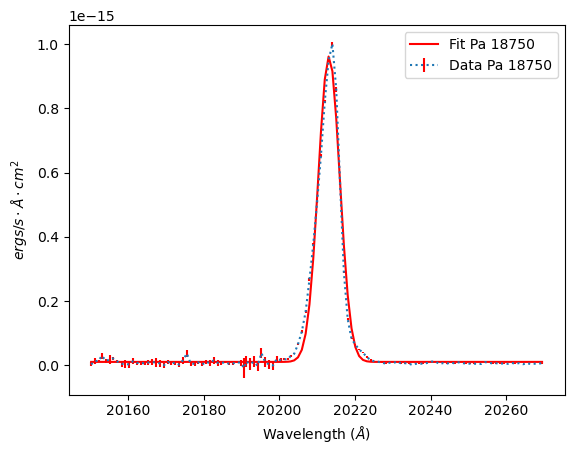

20213.11058988669 2.832897273429002 9.508378442670702e-16 1.0856657815861349e-17


In [66]:
# Paschen Alpha 4 -> 3
subset_indices = (wave > 20150) & (wave < 20270)
wave_subset = wave[subset_indices]
flux_subset = flux[subset_indices]

# 1 Gaussian
# Guess initial values for the parameters (1 Gaussian)
p0 = [20213.11, 2.83, 9.508e-16,1.085e-17]

# Fit the data
popt, pcov = curve_fit(gaussian, wave_subset, flux_subset, p0)
mu1, sigma1, A1, c = popt
#flux1 = A1*sigma1*np.sqrt(2*np.pi)
plt.clf()
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices],ls='dotted', label='Data Pa 18750')
bars[-1][0].set_color('red')
#plt.plot(wave_subset, flux_subset, 'b.', label='data')
plt.plot(wave_subset, gaussian(wave_subset, *popt), 'r-', label='Fit Pa 18750')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$ergs / s \cdot \AA \cdot cm^2}$')
plt.legend()
plt.show()
print(mu1, sigma1, A1, c)

In [67]:
print(mu1, sigma1, A1, c)
print(len(popt))

20213.11058988669 2.832897273429002 9.508378442670702e-16 1.0856657815861349e-17
4


# Dos Gaussianas

In [68]:
# 2 Gaussians
# Guess initial values for the parameters (2 Gaussians)
p2 = [20200, 2.83, 1e-17, 20200, 2.83, 1e-17, 0]

# Fit the data
popt2, pcov2 = curve_fit(doubleGaussian, wave_subset, flux_subset, p2)
mu1, sigma1, A1, mu2, sigma2, A2, continuo = popt2
#flux1 = A1*sigma1*np.sqrt(2*np.pi)

In [69]:
# Print the fitted parameters
print("Fitted parameters: ")
print('Center:', mu1)
print('Sigma:', sigma1)
print('Amplitude:', A1)
print('Continuo:', continuo)

Fitted parameters: 
Center: 20214.221765600214
Sigma: -1.561029184465743
Amplitude: 4.560370482260665e-16
Continuo: 9.590708597923117e-18


In [70]:
print(mu1, sigma1, A1, mu2, sigma2, A2, continuo)

20214.221765600214 -1.561029184465743 4.560370482260665e-16 20212.245685777387 3.222218046620882 6.333699949193229e-16 9.590708597923117e-18


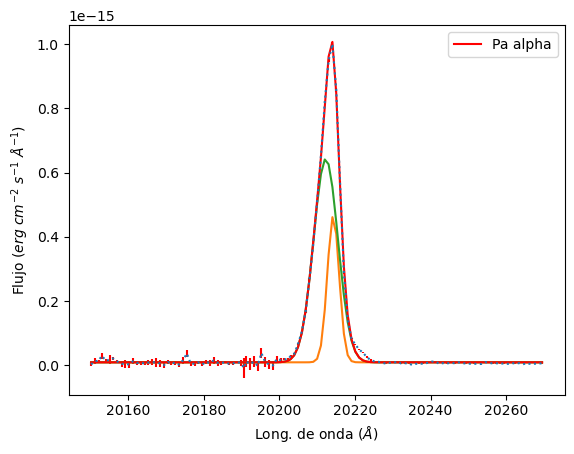

In [71]:
# Plot the data and the fitted function
plt.clf()
#plt.plot(waveClean,fluxClean, label='data')
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices],ls='dotted')
bars[-1][0].set_color('red')
#plt.plot(wave_subset, 1/ivar[subset_indices], label='ivar', color='black')
plt.plot(wave_subset,gaussian(wave_subset, mu1, sigma1, A1, continuo))
plt.plot(wave_subset,gaussian(wave_subset, mu2, sigma2, A2, continuo))
plt.plot(wave_subset, doubleGaussian(wave_subset, *popt2), 'r-', label='Pa alpha')
plt.xlabel(r'Long. de onda ($\AA$)')
plt.ylabel(r'Flujo ($erg$ $cm^{-2}$ $s^{-1}$ $\AA^{-1}$)')
plt.legend()
plt.show()

# Tres Gaussianas

In [72]:
# 3 Gaussians
# Guess initial values for the parameters (3 Gaussians)
p3 = [20212, 3.237, 6.316e-16, 20214.210, 1.550 , 4.612e-16 , 20214.210, 2.550 , 1e-17 , 9.264e-18]

# Fit the data
popt3, pcov3 = curve_fit(tripleGaussian, wave_subset, flux_subset, p3)
mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3, continuo = popt3
#flux1 = A1*sigma1*np.sqrt(2*np.pi)

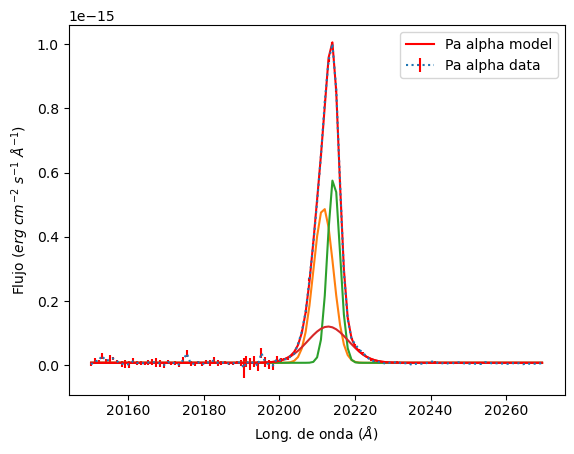

In [73]:
# Plot the data and the fitted function
plt.clf()
#plt.plot(waveClean,fluxClean, label='data')
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices],ls='dotted', label='Pa alpha data')
bars[-1][0].set_color('red')
#plt.plot(wave_subset, 1/ivar[subset_indices], label='ivar', color='black')
plt.plot(wave_subset,gaussian(wave_subset, mu1, sigma1, A1, continuo))
plt.plot(wave_subset,gaussian(wave_subset, mu2, sigma2, A2, continuo))
plt.plot(wave_subset,gaussian(wave_subset, mu3, sigma3, A3, continuo))
plt.plot(wave_subset, tripleGaussian(wave_subset, *popt3), 'r-', label='Pa alpha model')
plt.xlabel(r'Long. de onda ($\AA$)')
plt.ylabel(r'Flujo ($erg$ $cm^{-2}$ $s^{-1}$ $\AA^{-1}$)')
plt.legend()
plt.savefig('pa.pdf')
plt.show()

In [74]:
# Print the fitted parameters
print("Fitted parameters: ")
print('Center1:', mu1)
print('Sigma1:', sigma1)
print('Amplitude1:', A1)
print('Center2:', mu2)
print('Sigma2:', sigma2)
print('Amplitude2:', A2)
print('Center3:', mu3)
print('Sigma3:', sigma3)
print('Amplitude3:', A3)
print('Continuo:', continuo)

Fitted parameters: 
Center1: 20211.63042413655
Sigma1: 2.6207791714617596
Amplitude1: 4.824108278966531e-16
Center2: 20214.337201633072
Sigma2: 1.6483093650329803
Amplitude2: 5.782789919583332e-16
Center3: 20212.87869320506
Sigma3: 5.363237658349437
Amplitude3: 1.128126498332361e-16
Continuo: 8.078051576865439e-18


In [75]:
std = 1/ivar[subset_indices]
l = len(std)
print(popt3)

[2.02116304e+04 2.62077917e+00 4.82410828e-16 2.02143372e+04
 1.64830937e+00 5.78278992e-16 2.02128787e+04 5.36323766e+00
 1.12812650e-16 8.07805158e-18]


In [76]:
random_set = np.random.uniform(flux_subset[1]-std[1], flux_subset[1]+std[1], 5)
print(random_set)

[1.55816899e-17 1.07218790e-17 1.73722165e-17 1.53836808e-17
 1.35496172e-17]


# Ahora creamos un gran numero de valores aleatoreos alrededor del flujo dentro de la varianza de cada uno.


In [77]:
N=200
fluxes = np.zeros((l, N))
std = 1/ivar[subset_indices]
for i in range(l):
    random_set = np.random.uniform(flux_subset[i]-std[i], flux_subset[i]+std[i], N)
    fluxes[i][:] = random_set

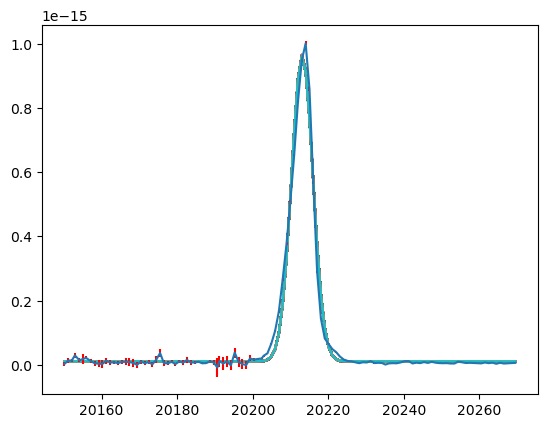

In [78]:
datos = np.zeros((N,4))
p0 = [20213.11, 2.83, 9.508e-16,1.085e-17]
for i in range(N):
    flujo = fluxes[:,i]
    # Fit the data
    popt, pcov = curve_fit(gaussian, wave_subset, flujo, p0)
    datos[i][:] = popt
    mu1, sigma1, A1, continuo = popt
    plt.plot(wave_subset,gaussian(wave_subset, mu1, sigma1, A1, continuo))
    plt.plot(wave_subset, gaussian(wave_subset, *popt))
    #flux1 = A1*sigma1*np.sqrt(2*np.pi)
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices])
bars[-1][0].set_color('red')

In [79]:
mu1 = ufloat(np.mean(datos[:,0]),np.std(datos[:,0]))
sigma1 = ufloat(np.mean(datos[:,1]),np.std(datos[:,1]))
A1 = ufloat(np.mean(datos[:,2]),np.std(datos[:,2]))
continuo = ufloat(np.mean(datos[:,3]),np.std(datos[:,3]))
print(mu1, sigma1, A1, continuo)

20213.111+/-0.005 2.833+/-0.006 (9.506+/-0.017)e-16 (1.09+/-0.05)e-17


In [80]:
flux1=np.sqrt(2*np.pi) * (A1*sigma1)
#flux2 = 6.874929896990473e-15+/-5.323441387642116e-17
intrinsicFlux1 = 4*np.pi*lumDist**2*flux1
print(4*np.pi*lumDist**2*flux1)
SFR = intrinsicFlux1*6.2e-41
SFR

(1.0099+/-0.0027)e+41


6.261276886396742+/-0.016688842117554323

# ChiSquared: 1 Gaussian model for Paschen alpha

In [81]:
# datos Paschen Alpha = flux_subset
fluxModel = gaussian(wave_subset, 20213.111, 2.833, 9.509e-16, 1.09e-17)

# Calculate the residuals
residuals = flux_subset - fluxModel

# Calculate the reduced chi-squared
chi_squared = np.sum((residuals / flux_subset) ** 2) / (len(wave_subset) - 4)
reduced_chi_squared = chi_squared / (len(wave_subset) - 4)

print("Reduced chi-squared:", reduced_chi_squared) # 0.2147570157626356

Reduced chi-squared: 0.2147570157626356


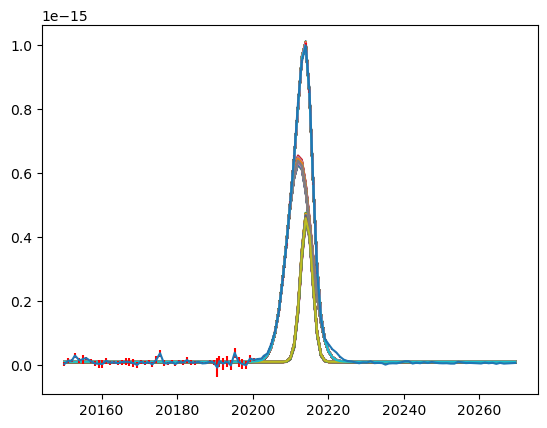

In [82]:
datos = np.zeros((N,7))
p0 = [20212, 3.237, 6.316e-16, 20214.210, 1.550 , 4.612e-16 , 9.264e-18]
for i in range(N):
    flujo = fluxes[:,i]
    # Fit the data
    popt, pcov = curve_fit(doubleGaussian, wave_subset, flujo, p0)
    datos[i][:] = popt
    mu1, sigma1, A1, mu2, sigma2, A2, continuo = popt
    plt.plot(wave_subset,gaussian(wave_subset, mu1, sigma1, A1, continuo))
    plt.plot(wave_subset,gaussian(wave_subset, mu2, sigma2, A2, continuo))
    plt.plot(wave_subset, doubleGaussian(wave_subset, *popt))
    #flux1 = A1*sigma1*np.sqrt(2*np.pi)
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices])
bars[-1][0].set_color('red')

In [83]:
mu1 = ufloat(np.mean(datos[:,0]),np.std(datos[:,0]))
sigma1 = ufloat(np.mean(datos[:,1]),np.std(datos[:,1]))
A1 = ufloat(np.mean(datos[:,2]),np.std(datos[:,2]))
mu2 = ufloat(np.mean(datos[:,3]),np.std(datos[:,3]))
sigma2 = ufloat(np.mean(datos[:,4]),np.std(datos[:,4]))
A2 = ufloat(np.mean(datos[:,5]),np.std(datos[:,5]))
continuo = ufloat(np.mean(datos[:,6]),np.std(datos[:,6]))
# Print the fitted parameters
print("Fitted parameters: ")
print('Center1:', mu1)
print('Sigma1:', sigma1)
print('Amplitude1:', A1)
print('Center2:', mu2)
print('Sigma2:', sigma2)
print('Amplitude2:', A2)
print('Continuo:', continuo)

Fitted parameters: 
Center1: 20212.246+/-0.016
Sigma1: 3.222+/-0.013
Amplitude1: (6.33+/-0.06)e-16
Center2: 20214.222+/-0.016
Sigma2: 1.561+/-0.015
Amplitude2: (4.56+/-0.05)e-16
Continuo: (9.6+/-0.5)e-18


In [84]:
flux2=np.sqrt(2*np.pi) * (A1*sigma1 + A2*sigma2)
#flux2 = 6.874929896990473e-15+/-5.323441387642116e-17
intrinsicFlux2 = 4*np.pi*lumDist**2*flux2
SFR = intrinsicFlux2*6.2e-41
SFR

6.39864853933972+/-0.052666047963686596

In [85]:
#np.savetxt("100rn.csv", datos, delimiter=",")

# ChiSquared: 2 Gaussian model for Paschen alpha

In [86]:
# datos Paschen Alpha = flux_subset
fluxModel_2 = doubleGaussian(wave_subset, 20212.247, 3.2267720654255054, 6.34e-16, 20214.223, 1.561, 4.56e-16, 9.6e-18)

# Calculate the residuals
residuals = flux_subset - fluxModel_2

# Calculate the reduced chi-squared
chi_squared = np.sum((residuals / flux_subset) ** 2) / (len(wave_subset) - 7)
reduced_chi_squared = chi_squared / (len(wave_subset) - 7)

print("Reduced chi-squared:", reduced_chi_squared) # 0.17549956974584416

Reduced chi-squared: 0.17549956974584416


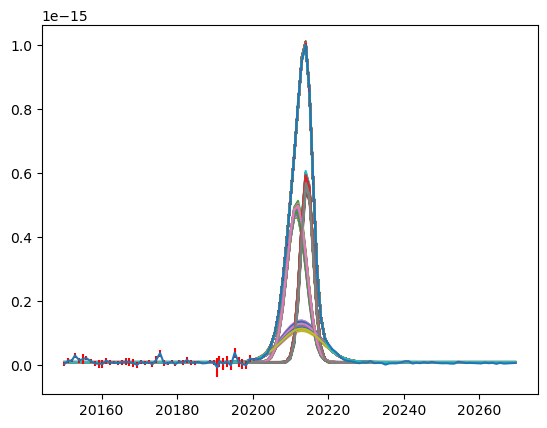

In [87]:
datos = np.zeros((N,10))
p0 = [2.02116304e+04, 2.62088,  4.8241e-16,  2.0214e+04, 1.6483,  5.7828e-16,  2.0213e+04, 5.3632, 1.1281e-16,  8.0781e-18]
for i in range(N):
    flujo = fluxes[:,i]
    # Fit the data
    popt3, pcov3 = curve_fit(tripleGaussian, wave_subset, flujo, p0)
    datos[i][:] = popt3
    mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3, continuo = popt3
    plt.plot(wave_subset,gaussian(wave_subset, mu1, sigma1, A1, continuo))
    plt.plot(wave_subset,gaussian(wave_subset, mu2, sigma2, A2, continuo))
    plt.plot(wave_subset,gaussian(wave_subset, mu3, sigma3, A3, continuo))
    plt.plot(wave_subset, tripleGaussian(wave_subset, *popt3))
    #flux1 = A1*sigma1*np.sqrt(2*np.pi)
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices])
bars[-1][0].set_color('red')

In [88]:
mu1 = ufloat(np.mean(datos[:,0]),np.std(datos[:,0]))
sigma1 = ufloat(np.mean(datos[:,1]),np.std(datos[:,1]))
A1 = ufloat(np.mean(datos[:,2]),np.std(datos[:,2]))
mu2 = ufloat(np.mean(datos[:,3]),np.std(datos[:,3]))
sigma2 = ufloat(np.mean(datos[:,4]),np.std(datos[:,4]))
A2 = ufloat(np.mean(datos[:,5]),np.std(datos[:,5]))
mu3 = ufloat(np.mean(datos[:,6]),np.std(datos[:,6]))
sigma3 = ufloat(np.mean(datos[:,7]),np.std(datos[:,7]))
A3 = ufloat(np.mean(datos[:,8]),np.std(datos[:,8]))
continuo = ufloat(np.mean(datos[:,9]),np.std(datos[:,9]))

In [89]:
flux3=np.sqrt(2*np.pi) * (A1*sigma1 + A2*sigma2 + A3*sigma3)
flux3 

7.073714523812831e-15+/-1.11788271373915e-16

In [90]:
intrinsicFlux = 4*np.pi*lumDist**2*flux3
intrinsicFlux

1.058369167115795e+41+/-1.6725761163959494e+39

In [91]:
SFR = intrinsicFlux*6.2e-41
SFR

6.561888836117928+/-0.10369971921654886

In [92]:
# Print the fitted parameters
print("Fitted parameters: ")
print('Center1:', mu1)
print('Sigma1:', sigma1)
print('Amplitude1:', A1)
print('Center2:', mu2)
print('Sigma2:', sigma2)
print('Amplitude2:', A2)
print('Center3:', mu3)
print('Sigma3:', sigma3)
print('Amplitude3:', A3)
print('Continuo:', continuo)

Fitted parameters: 
Center1: 20211.63+/-0.05
Sigma1: 2.621+/-0.017
Amplitude1: (4.82+/-0.08)e-16
Center2: 20214.337+/-0.019
Sigma2: 1.648+/-0.018
Amplitude2: (5.78+/-0.10)e-16
Center3: 20212.88+/-0.07
Sigma3: 5.37+/-0.11
Amplitude3: (1.13+/-0.06)e-16
Continuo: (8.1+/-0.5)e-18


# ChiSquared: 3 Gaussian model for Paschen alpha

In [93]:
# datos Paschen Alpha = flux_subset
fluxModel_3 = tripleGaussian(wave_subset, 20211.62,2.621,4.82e-16,20214.336,1.650,5.79e-16,20212.89,5.37,1.12e-16,8.1e-18)

# Calculate the residuals
residuals = flux_subset - fluxModel_3

# Calculate the reduced chi-squared
chi_squared = np.sum((residuals / flux_subset) ** 2) / (len(wave_subset) - 10)
reduced_chi_squared = chi_squared / (len(wave_subset) - 10)

print("Reduced chi-squared:", reduced_chi_squared) # 0.17100801840269855

Reduced chi-squared: 0.17100801840269855


## Findind the numerical flux of Pa-$\alpha$ fitting a straight line in the continuous

m: [4.16336298e-22]
7.037331298168413e-15


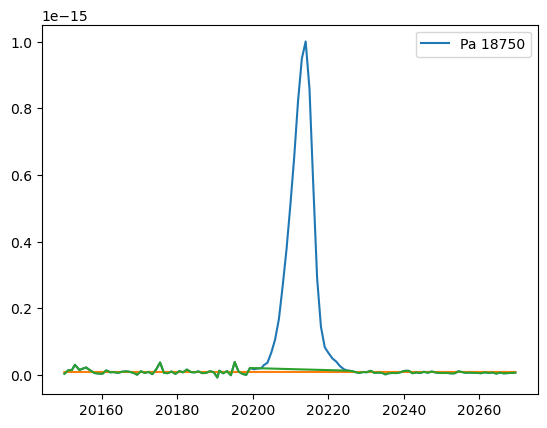

In [94]:
plt.plot(wave_subset, flux_subset, label='Pa 18750')
recta1_indices = (wave < 20200) & (wave > 20150)
recta2_indices = (wave < 20270) & (wave > 20225)

rectax_subset = np.concatenate((wave[recta1_indices], wave[recta2_indices]))
rectay_subset = np.concatenate((flux[recta1_indices], flux[recta2_indices]))


# Fit the data
popt, pcov = curve_fit(recta, rectax_subset, rectay_subset, [0])
m = popt
plt.plot(rectax_subset, recta(rectax_subset, *popt))
plt.plot(rectax_subset,rectay_subset)
print('m:',m)

intFlux=np.trapz(flux_subset,wave_subset)
intRec=np.trapz(recta(rectax_subset, *popt),rectax_subset)
print(intFlux-intRec)
plt.legend()

# Paschen-$\gamma$

11790.92363072129 -1.980456544347003 2.965605119109842e-16 1.905245048320947e-17


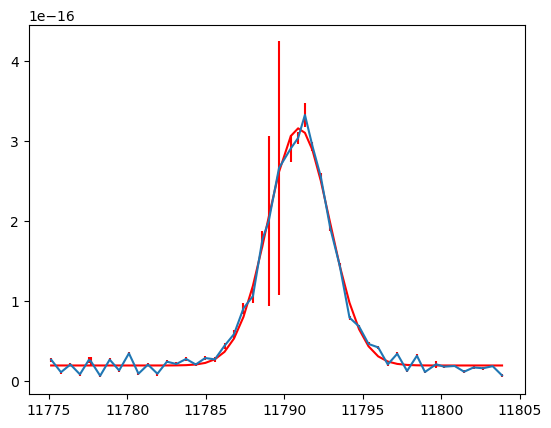

In [95]:
# Linea 10941 Paschen 6 -> 3
# Guess initial values for the parameters
subset_AD = (wave > 11775) & (wave < 11804)
wave_AD = wave[subset_AD]
flux_AD = flux[subset_AD]
pAD = [11790, 5, 1e-17,0]
# Fit the data
poptAD, pcovAD = curve_fit(gaussian, wave_AD, flux_AD, pAD)

muGamma, sigmaGamma, AGamma, cGamma = poptAD
plt.plot(wave_AD,gaussian(wave_AD, *poptAD), 'r-', label='Pa-$\gamma$')
bars = plt.errorbar(wave_AD, flux_AD,yerr=1/ivar[subset_AD])
bars[-1][0].set_color('red')
print(muGamma, sigmaGamma, AGamma, cGamma)

m: 1.5737927068118691e-21
1.4834032386870493e-15


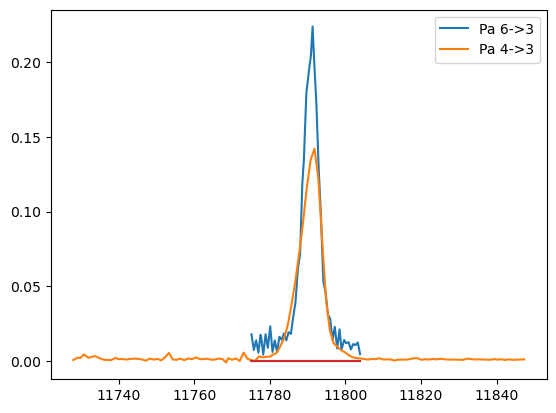

In [96]:
plt.plot(wave_AD, flux_AD/1.4834032386870493e-15, label='Pa 6->3')
plt.plot(wave_subset-8422.179, flux_subset/7.037331298168413e-15, label='Pa 4->3')
plt.legend()
recta1_indices = (wave < 11784) & (wave > 11775)
recta2_indices = (wave < 11804) & (wave > 11796)

rectax_subset = np.concatenate((wave[recta1_indices], wave[recta2_indices]))
rectay_subset = np.concatenate((flux[recta1_indices], flux[recta2_indices]))


# Fit the data
popt, pcov = curve_fit(recta, rectax_subset, rectay_subset, [0])
m = popt
plt.plot(rectax_subset, recta(rectax_subset, *popt))
plt.plot(rectax_subset,rectay_subset)
print('m:',m[0])

intFlux=np.trapz(flux_AD,wave_AD)
intRec=np.trapz(recta(rectax_subset, *popt),rectax_subset)
print(intFlux-intRec)

# Ahora vamos a la linea que no es Paschen-$\gamma$

11674.826804102013 2.4413107316205247 1.1780576444302662e-15 2.1021527521280096e-17


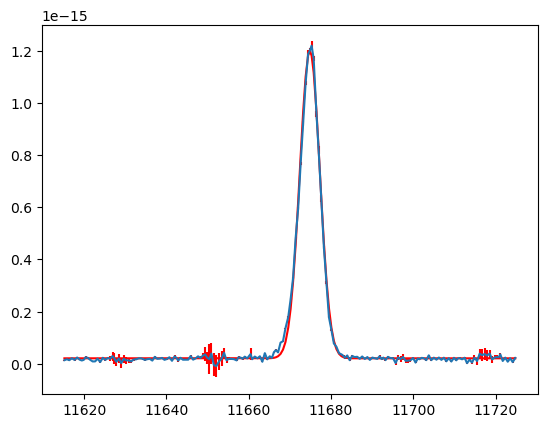

In [97]:
subset_10941 = (wave > 11615) & (wave < 11725)
wave_10941 = wave[subset_10941]
flux_10941 = flux[subset_10941]

# Fit the data
p10941 = [11675, 10, 1e-17,0]
popt10941, pcov10941 = curve_fit(gaussian, wave_10941, flux_10941, p10941)
mu10941, sigma10941, A10941, c10941 = popt10941
flux10941 = A10941*sigma10941*np.sqrt(2*np.pi)
plt.plot(wave_10941,gaussian(wave_10941, *popt10941), 'r-', label='Pa 10941')
bars = plt.errorbar(wave_10941, flux_10941,yerr=1/ivar[subset_10941])
bars[-1][0].set_color('red')
print(mu10941, sigma10941, A10941, c10941)

In [98]:
# 2 Gaussians
# Guess initial values for the parameters (2 Gaussians)
p2 = [11674, 3.221, 4.83168741e-16, 11675, 1.561, 7.33599724e-16, 1.97069031e-17]

# Fit the data
popt2, pcov2 = curve_fit(doubleGaussian, wave_10941, flux_10941, p2)
mu1, sigma1, A1, mu2, sigma2, A2, continuo = popt2
#flux1 = A1*sigma1*np.sqrt(2*np.pi)

In [99]:
# Print the fitted parameters
print("Fitted parameters: ")
print('Center1:', mu1)
print('Sigma1:', sigma1)
print('Amplitude1:', A1)
print('Center2:', mu2)
print('Sigma2:', sigma2)
print('Amplitude2:', A2)
print('Continuo:', continuo)

Fitted parameters: 
Center1: 11674.177580946134
Sigma1: 3.032846193372236
Amplitude1: 4.831996407698717e-16
Center2: 11675.167773904095
Sigma2: 1.9972972778022042
Amplitude2: 7.335692496435558e-16
Continuo: 1.970693464459415e-17


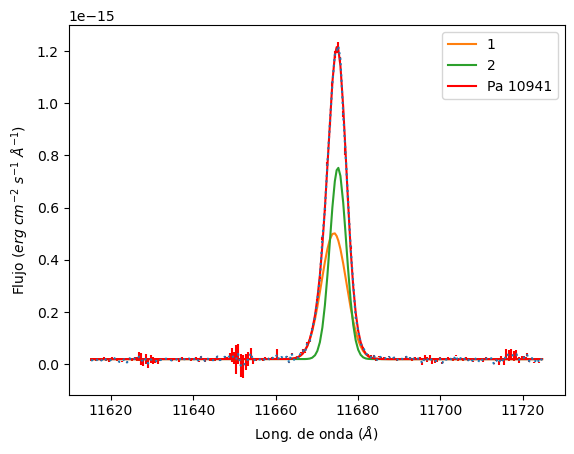

In [100]:
# Plot the data and the fitted function
plt.clf()
#plt.plot(waveClean,fluxClean, label='data')
bars = plt.errorbar(wave_10941, flux_10941,yerr=1/ivar[subset_10941],ls='dotted')
bars[-1][0].set_color('red')
#plt.plot(wave_subset, 1/ivar[subset_indices], label='ivar', color='black')
plt.plot(wave_10941,gaussian(wave_10941, mu1, sigma1, A1, continuo),label='1')
plt.plot(wave_10941,gaussian(wave_10941, mu2, sigma2, A2, continuo),label='2')
plt.plot(wave_10941, doubleGaussian(wave_10941, *popt2), 'r-', label='Pa 10941')
plt.xlabel(r'Long. de onda ($\AA$)')
plt.ylabel(r'Flujo ($erg$ $cm^{-2}$ $s^{-1}$ $\AA^{-1}$)')
plt.legend()
plt.show()

In [101]:
std_10941 = 1/ivar[subset_10941]
l_10941 = len(std_10941)

N=200
fluxes_10941 = np.zeros((l_10941, N))

for i in range(l):
    fluxes_10941[i][:] = np.random.uniform(flux_10941[i]-std_10941[i], flux_10941[i]+std_10941[i], N)

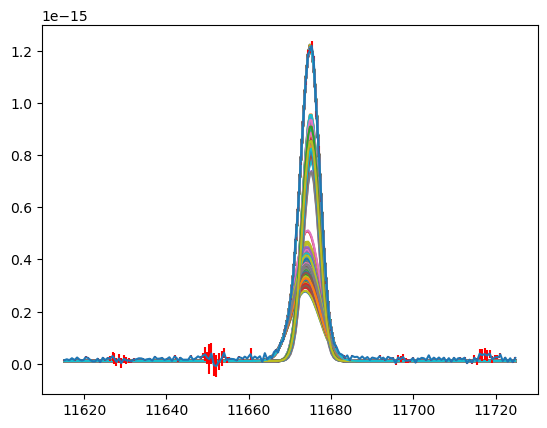

In [102]:
datos = np.zeros((N,7))
p0 = [11674, 3.221, 3.5e-16, 11675, 2, 7.33599724e-16, 1e-17]
for i in range(N):
    flujo_10941 = fluxes_10941[:,i]
    # Fit the data
    popt, pcov = curve_fit(doubleGaussian, wave_10941, flujo_10941, p0)
    datos[i][:] = popt
    mu1, sigma1, A1, mu2, sigma2, A2, continuo = popt
    plt.plot(wave_10941,gaussian(wave_10941, mu1, sigma1, A1, continuo))
    plt.plot(wave_10941,gaussian(wave_10941, mu2, sigma2, A2, continuo))
    plt.plot(wave_10941, doubleGaussian(wave_10941, *popt))
    #flux1 = A1*sigma1*np.sqrt(2*np.pi)
bars = plt.errorbar(wave_10941, flux_10941,yerr=1/ivar[subset_10941])
bars[-1][0].set_color('red')

In [103]:
mu1 = ufloat(np.mean(datos[:,0]),np.std(datos[:,0]))
sigma1 = ufloat(np.mean(datos[:,1]),np.std(datos[:,1]))
A1 = ufloat(np.mean(datos[:,2]),np.std(datos[:,2]))
mu2 = ufloat(np.mean(datos[:,3]),np.std(datos[:,3]))
sigma2 = ufloat(np.mean(datos[:,4]),np.std(datos[:,4]))
A2 = ufloat(np.mean(datos[:,5]),np.std(datos[:,5]))
continuo = ufloat(np.mean(datos[:,6]),np.std(datos[:,6]))
# Print the fitted parameters
print("Fitted parameters: ")
print('Center1:', mu1)
print('Sigma1:', sigma1)
print('Amplitude1:', A1)
print('Center2:', mu2)
print('Sigma2:', sigma2)
print('Amplitude2:', A2)
print('Continuo:', continuo)
# print(max(datos[:,2]),min(datos[:,2]))

Fitted parameters: 
Center1: 11673.97+/-0.10
Sigma1: 3.33+/-0.07
Amplitude1: (3.7+/-0.4)e-16
Center2: 11675.092+/-0.024
Sigma2: 2.08+/-0.04
Amplitude2: (8.6+/-0.4)e-16
Continuo: (1.04+/-0.05)e-17


In [104]:
# datos Paschen Alpha = flux_subset
fluxModel_2 = doubleGaussian(wave_10941, 11673.97, 3.34, 3.65e-16, 11675.091, 2.077, 8.58e-16, 1.04e-17)

# Calculate the residuals
residuals = flux_10941 - fluxModel_2

# Calculate the reduced chi-squared
chi_squared = np.sum((residuals / flux_10941) ** 2) / (len(wave_10941) - 7)
reduced_chi_squared = chi_squared / (len(wave_10941) - 7)

print("Reduced chi-squared:", reduced_chi_squared) # 0.0023773915160460934

Reduced chi-squared: 0.0023773915160460934


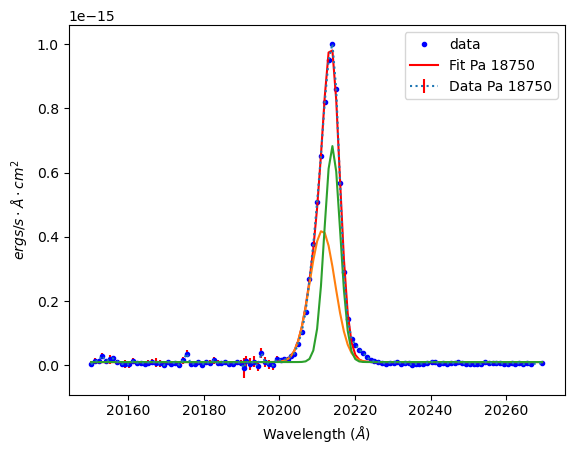

[2.02113395e+04 4.09319974e-16 2.02139754e+04 6.71913597e-16]


In [105]:
# Define another function to fit (Paschen-10941 two Gaussian curves model)
def pa10941Model(x,mu1,A1,mu2,A2):
    return doubleGaussian(x, mu1, 3.34, A1, mu2, 2.077, A2, 1.04e-17)

# Paschen Alpha 4 -> 3
subset_indices = (wave > 20150) & (wave < 20270)
wave_subset = wave[subset_indices]
flux_subset = flux[subset_indices]

# 1 Gaussian
# Guess initial values for the parameters (1 Gaussian)
p0 = [2.02113395e+04, 4.09319973e-16, 2.02139754e+04, 6.71913598e-16]

# Fit the data
popt, pcov = curve_fit(pa10941Model, wave_subset, flux_subset, p0)
mu1,A1,mu2,A2 = popt

plt.clf()
bars = plt.errorbar(wave_subset, flux_subset,yerr=1/ivar[subset_indices],ls='dotted', label='Data Pa 18750')
bars[-1][0].set_color('red')
plt.plot(wave_subset, flux_subset, 'b.', label='data')
plt.plot(wave_subset, pa10941Model(wave_subset, *popt), 'r-', label='Fit Pa 18750')
plt.plot(wave_subset,gaussian(wave_subset, mu1, 3.34, A1, 1.04e-17))
plt.plot(wave_subset,gaussian(wave_subset, mu2, 2.077, A2, 1.04e-17))
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$ergs / s \cdot \AA \cdot cm^2}$')
plt.legend()
plt.show()
print(popt)

In [106]:
# 3 Gaussians
# Guess initial values for the parameters (3 Gaussians)
p3 = [11674, 3.221, 5.31588e-16, 11675, 1.561, 7.33599724e-16,11674, 3, 1.50588e-16, 9.264e-18]

# Fit the data
popt3, pcov3 = curve_fit(tripleGaussian, wave_10941, flux_10941, p3)
mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3, continuo = popt3
#flux1 = A1*sigma1*np.sqrt(2*np.pi)
print(mu1, sigma1, A1)
print(mu2, sigma2, A2)
print(mu3, sigma3, A3)
print(continuo)

11674.07567585798 3.17273802939533 3.878201729159649e-16
11675.113144303294 2.04816684862297 8.272065249278356e-16
11671.606472797397 0.15361801663076638 1.0675891481059231e-16
1.9610968660263252e-17


In [107]:
1.997*1.5875227135069654

3.17028285887341

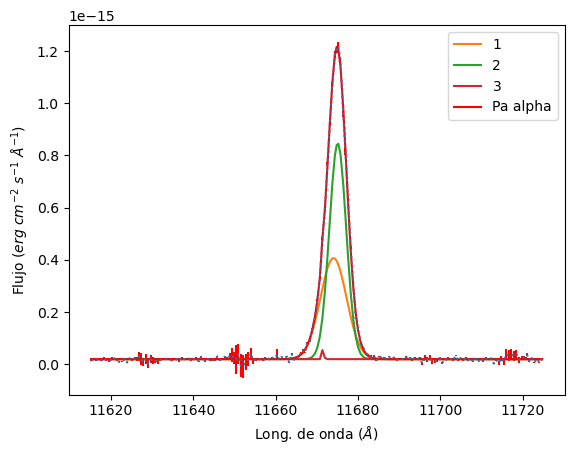

In [108]:
# Plot the data and the fitted function
plt.clf()
#plt.plot(waveClean,fluxClean, label='data')
bars = plt.errorbar(wave_10941, flux_10941,yerr=1/ivar[subset_10941],ls='dotted')
bars[-1][0].set_color('red')
#plt.plot(wave_subset, 1/ivar[subset_indices], label='ivar', color='black')
plt.plot(wave_10941,gaussian(wave_10941, mu1, sigma1, A1, continuo),label='1')
plt.plot(wave_10941,gaussian(wave_10941, mu2, sigma2, A2, continuo),label='2')
plt.plot(wave_10941,gaussian(wave_10941, mu3, sigma3, A3, continuo),label='3')
plt.plot(wave_10941, tripleGaussian(wave_10941, *popt3), 'r-', label='Pa alpha')
plt.xlabel(r'Long. de onda ($\AA$)')
plt.ylabel(r'Flujo ($erg$ $cm^{-2}$ $s^{-1}$ $\AA^{-1}$)')
plt.legend()
plt.show()


m: [1.68421443e-21]
7.34754947152383e-15


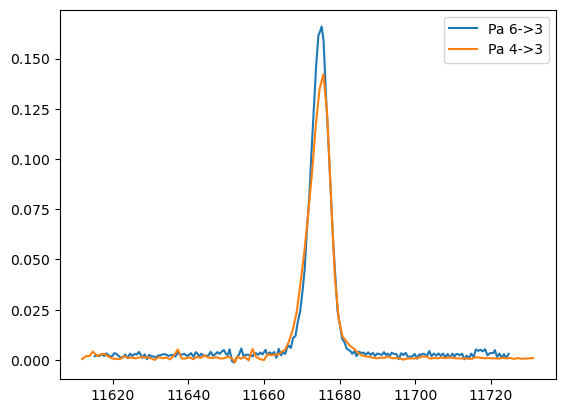

In [109]:
plt.plot(wave_10941, flux_10941/7.34754947152383e-15, label='Pa 6->3')
plt.plot(wave_subset-8538.284, flux_subset/7.037331298168413e-15, label='Pa 4->3')
plt.legend()
recta1_indices = (wave < 11665) & (wave > 11615)
recta2_indices = (wave < 11725) & (wave > 11685)

rectax_subset = np.concatenate((wave[recta1_indices], wave[recta2_indices]))
rectay_subset = np.concatenate((flux[recta1_indices], flux[recta2_indices]))


# Fit the data
popt, pcov = curve_fit(recta, rectax_subset, rectay_subset, [0])
m = popt
#plt.plot(rectax_subset, recta(rectax_subset, *popt))
#plt.plot(rectax_subset,rectay_subset)
print('m:',m)

intFlux=np.trapz(flux_10941,wave_10941)
intRec=np.trapz(recta(rectax_subset, *popt),rectax_subset)
print(intFlux-intRec)

10832.996373686829 2.001134840501868 1.7172155678263136e-16 1.702058764198551e-17


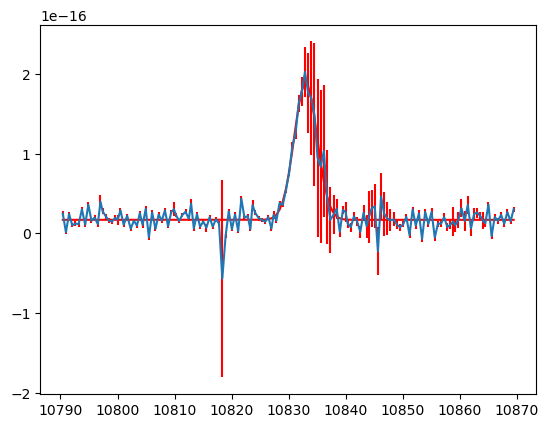

In [110]:
# Linea 10052 Paschen 7 -> 3

subset_10052 = (wave > 10790) & (wave < 10870)
wave_10052 = wave[subset_10052]
flux_10052 = flux[subset_10052]

# Fit the data
p10052 = [10833, 3, 1e-17,0]
popt10052, pcov10052 = curve_fit(gaussian, wave_10052, flux_10052, p10052)
mu10052, sigma10052, A10052, c10052 = popt10052
flux10052 = A10052*sigma10052*np.sqrt(2*np.pi)
bars = plt.errorbar(wave_10052, flux_10052,yerr=1/ivar[subset_10052])
bars[-1][0].set_color('red')
plt.plot(wave_10052,gaussian(wave_10052, *popt10052), 'r-', label='Pa 10052')
print(mu10052, sigma10052, A10052, c10052)

m: [1.58968019e-21]
8.282700182309565e-16


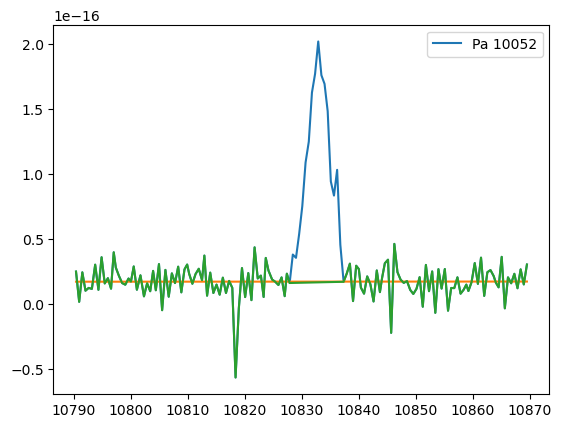

In [111]:
#plt.plot(wave_10941, flux_10941/7.333999844147504e-15, label='Pa 10941')
#plt.plot(wave_subset-8538.284, flux_subset/7.047289832048305e-15, label='Pa 18750')
#plt.plot(wave_10052+841.83, flux_10052/8.438805628956373e-16, label='Pa 10052')
plt.plot(wave_10052, flux_10052, label='Pa 10052')
recta1_indices = (wave < 10828) & (wave > 10790)
recta2_indices = (wave < 10870) & (wave > 10837)

rectax_subset = np.concatenate((wave[recta1_indices], wave[recta2_indices]))
rectay_subset = np.concatenate((flux[recta1_indices], flux[recta2_indices]))


# Fit the data
popt, pcov = curve_fit(recta, rectax_subset, rectay_subset, [1])
m = popt

print('m:',m)

intFlux=np.trapz(flux_10052,wave_10052)
intRec=np.trapz(recta(rectax_subset, *popt),rectax_subset)
print(intFlux-intRec)
plt.plot(rectax_subset, recta(rectax_subset, *popt))
plt.plot(rectax_subset,rectay_subset,)
plt.legend()

In [112]:
11674.827-10832.997

841.8299999999999

# Linea por determinar pero muy fuerte

[1.02739253e+04 1.73385366e+00 1.35137173e-15 2.68681442e-17]


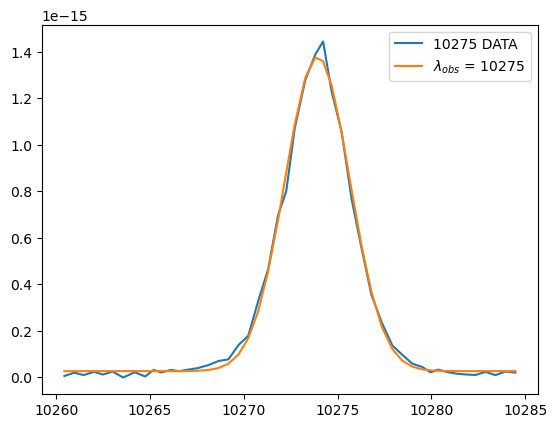

In [113]:
# Line at lamba_obs = 10260
# Guess initial values for the parameters
subset_DD = (wave > 10260) & (wave < 10285)
wave_DD = wave[subset_DD]
flux_DD = flux[subset_DD]
pDD = [1.02739250e+04, 1.78741628e+00, 1.36887792e-15,0]

# Fit the data
poptDD, pcovDD = curve_fit(gaussian, wave_DD, flux_DD, pDD)
plt.plot(wave_DD, flux_DD, label='10275 DATA')
plt.plot(wave_DD, gaussian(wave_DD, *poptDD), label='$\lambda_{obs}$ = 10275')
plt.legend()
print(poptDD)

In [114]:
# 2 Gaussians
# Guess initial values for the parameters (2 Gaussians)
p2 = [1.02739250e+04, 1.08416685e+00, 5.6138e-16, 1.02739250e+04, 1.78741628e+00, 7.336e-16, 1.97069031e-17]

# Fit the data
popt2, pcov2 = curve_fit(doubleGaussian, wave_DD, flux_DD, p2)
mu1, sigma1, A1, mu2, sigma2, A2, continuo = popt2
#flux1 = A1*sigma1*np.sqrt(2*np.pi)
print(popt2)

[1.02740670e+04 1.05969738e+00 3.81491900e-16 1.02738593e+04
 1.97334335e+00 1.01595411e-15 2.02374360e-17]


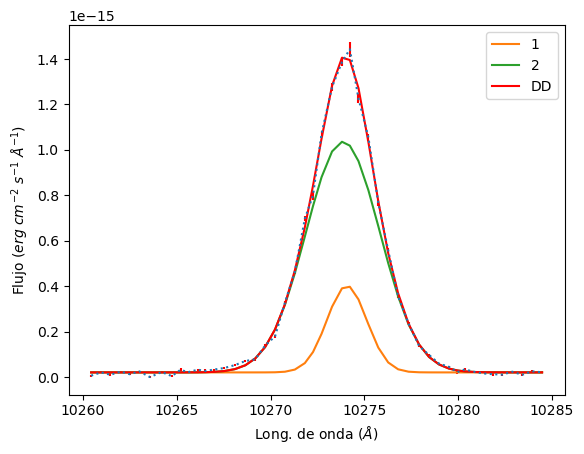

In [115]:
# Plot the data and the fitted function
plt.clf()
#plt.plot(waveClean,fluxClean, label='data')
bars = plt.errorbar(wave_DD, flux_DD,yerr=1/ivar[subset_DD],ls='dotted')
bars[-1][0].set_color('red')
#plt.plot(wave_subset, 1/ivar[subset_indices], label='ivar', color='black')
plt.plot(wave_DD,gaussian(wave_DD, mu1, sigma1, A1, continuo),label='1')
plt.plot(wave_DD,gaussian(wave_DD, mu2, sigma2, A2, continuo),label='2')
plt.plot(wave_DD, doubleGaussian(wave_DD, *popt2), 'r-', label='DD')
plt.xlabel(r'Long. de onda ($\AA$)')
plt.ylabel(r'Flujo ($erg$ $cm^{-2}$ $s^{-1}$ $\AA^{-1}$)')
plt.legend()
plt.show()

m: [1.68421443e-21]
7.34754947152383e-15


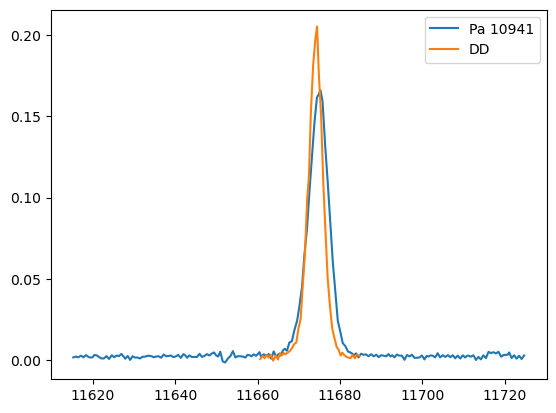

In [116]:
plt.plot(wave_10941, flux_10941/7.34754947152383e-15, label='Pa 10941')
plt.plot(wave_DD+1400.2, flux_DD/7.037331298168413e-15, label='DD')
plt.legend()
recta1_indices = (wave < 11665) & (wave > 11615)
recta2_indices = (wave < 11725) & (wave > 11685)

rectax_subset = np.concatenate((wave[recta1_indices], wave[recta2_indices]))
rectay_subset = np.concatenate((flux[recta1_indices], flux[recta2_indices]))


# Fit the data
popt, pcov = curve_fit(recta, rectax_subset, rectay_subset, [0])
m = popt
#plt.plot(rectax_subset, recta(rectax_subset, *popt))
#plt.plot(rectax_subset,rectay_subset)
print('m:',m)

intFlux=np.trapz(flux_10941,wave_10941)
intRec=np.trapz(recta(rectax_subset, *popt),rectax_subset)
print(intFlux-intRec)

In [117]:
11674.1-10273.9

1400.2000000000007

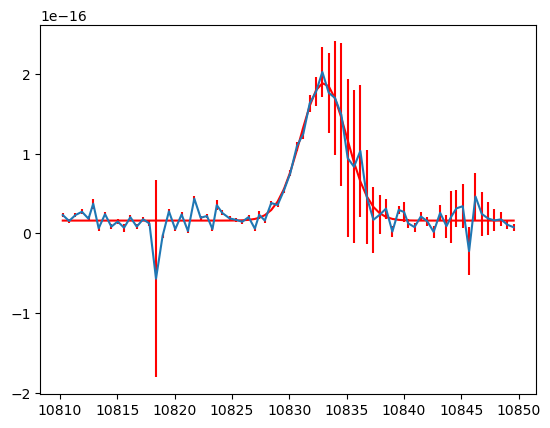

In [118]:
# Linea 10052 Paschen 7 -> 3

subset_10052 = (wave > 10810) & (wave < 10850)
wave_10052 = wave[subset_10052]
flux_10052 = flux[subset_10052]

# Fit the data
p10052 = [10833, 3, 1e-17,0]
popt10052, pcov10052 = curve_fit(gaussian, wave_10052, flux_10052, p10052)
mu10052, sigma10052, A10052, c10052 = popt10052
#flux10052 = A10052*sigma10052*np.sqrt(2*np.pi)

plt.plot(wave_10052,gaussian(wave_10052, *popt10052), 'r-', label='Pa-$\delta$')
bars = plt.errorbar(wave_10052, flux_10052,yerr=1/ivar[subset_10052])
bars[-1][0].set_color('red')

m: [1.53175623e-21]
8.458138249864565e-16
8.375485991783208e-16


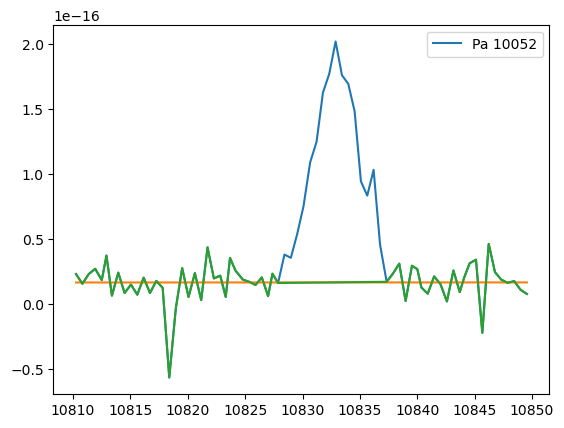

In [119]:
plt.plot(wave_10052, flux_10052, label='Pa 10052')
recta1_indices = (wave < 10828) & (wave > 10810)
recta2_indices = (wave < 10850) & (wave > 10837)
gauss_indices =  (wave > 10828) & (wave < 10837)

rectax_subset = np.concatenate((wave[recta1_indices], wave[recta2_indices]))
rectay_subset = np.concatenate((flux[recta1_indices], flux[recta2_indices]))


# Fit the data
popt, pcov = curve_fit(recta, rectax_subset, rectay_subset, [0])
m = popt
plt.plot(rectax_subset, recta(rectax_subset, *popt))
plt.plot(rectax_subset,rectay_subset)
print('m:',m)

otroIntFlux = np.trapz(flux[gauss_indices],wave[gauss_indices])
intFlux=np.trapz(flux_10052,wave_10052)
intRec=np.trapz(recta(rectax_subset, *popt),rectax_subset)
print(intFlux-intRec)
print(otroIntFlux-np.trapz(m[0]*wave[gauss_indices],wave[gauss_indices]))
plt.legend()